## Q1
### 1.1

Given
$$
x\mid \theta \;\sim\; \mathcal{N}\bigl(C\,\theta,\;Q\bigr),
\quad
y\mid x \;\sim\; \mathcal{N}\bigl(A\,x,\;R\bigr),
$$

We first compute the likelihood of y, given by

$$
p(y\mid \theta)
\;=\;\int p(y\mid x)\,p(x\mid \theta)\,dx.
$$

$$
= \int \mathcal{N}\bigl(y; A\,x,\;R\bigr) \mathcal{N}\bigl(x; C\,\theta,\;Q\bigr) dx
$$

We use the result from Lemma 3.2:

$$
= \mathcal{N}\!\Bigl(
y;\;A\,C\,\theta,\;A\,Q\,A^\top + R
\Bigr)
$$

Now we construct the posterior 
$$
p(\theta\mid y)
\propto
p(\theta) \; p(y\mid \theta)
$$

$$
\propto
\mathcal{N}\bigl(\theta; m \; P )
\;
\mathcal{N}\!\Bigl(
y;\;A\,C\,\theta,\;A\,Q\,A^\top + R
\Bigr)
$$

Write 
$$
p(\theta\mid y) = \mathcal{N}(y; \Mu, \Sigma)
$$
then using Lemma 3.1, the posterior covariance is given by
$$
\Sigma \;=\;
P - P (AC)^\top \Bigl( A\,Q\,A^\top + R + (AC) P (AC) ^\top \Bigr)^{-1} (AC) P
$$

Or equivalently in a more elegant form
$$
\Sigma \;=\;
\bigl[P^{-1} + C^\top A^\top (A\,Q\,A^\top + R)^{-1} A\,C\bigr]^{-1}.
$$ 





By Lemma 3.1, the posterior mean $\Mu$ is given by
$$
\Mu = m + P (AC)^\top \Bigl( A\,Q\,A^\top + R + (AC) P (AC) ^\top \Bigr)^{-1} (y - ACm)
$$

or more elegantly
$$
\Mu = \Sigma\bigl[P^{-1}m + C^\top A^\top (A\,Q\,A^\top + R)^{-1}y\bigr]
$$


### 1.2
We plug in those:
$$
m = \begin{pmatrix}2 \\[4pt] 0\end{pmatrix},\quad 
P = I_2,\quad
C = \begin{pmatrix}1 & 1\\[4pt] 1 & 1.01\end{pmatrix},\quad 
Q = 0.01\,I_2.
$$

$$
A = \begin{pmatrix}1 & 0 \\[4pt]\varepsilon & 0\end{pmatrix},\quad 
R = \varepsilon\,I_2,\quad
y = \begin{pmatrix}1\\[3pt]1\end{pmatrix}.
$$

Note when computing the posterior mean and var, I have checked that both expressions yield identical numerical values, so I will use only the more elegant format here


In [1]:
import numpy as np
import pandas as pd

m = np.array([[2], [0]])
P = np.eye(2)
C = np.array([[1, 1], [1, 1.01]])
Q = 0.01 * np.eye(2)
y = np.array([[1], [1]])
A_base = np.array([[1, 0], [0, 0]], dtype=float)  # Base part of A
R_base = np.array([[1, 0], [0, 1]], dtype=float)  # Base part of R

epsilons = np.logspace(-3, 0, num=4)  # 10^-3, 10^-2, 10^-1, 10^0
post_var = []
post_means = []

for epsilon in epsilons:
    A = A_base.copy()
    A[1, 0] = epsilon  # Update A with the varying epsilon
    R = epsilon * R_base  # Update R with the varying epsilon

    S = A @ Q @ A.T + R

    Sigma = np.linalg.inv(P + C.T @ A.T @ np.linalg.inv(S) @ A @ C)

    # Store the trace of Sigma (a measure of total variance)
    post_var.append(np.round(Sigma, 4))

    post_mean = Sigma @ (np.linalg.inv(P) @ m + C.T @ A.T @ np.linalg.inv(S) @ y)
    post_means.append(np.round(post_mean.flatten(), 4)) # store 4 digits

    # post_mean2 = m + P @ (A @ C).T @ np.linalg.inv(S + (A @ C) @ P @ (A @ C).T) @ (y - A @ C @ m)

# Create a DataFrame for visualization
df_post = pd.DataFrame(
    {"Epsilon": epsilons, 
    "Posterior Mean": post_means,
     "Posterior Variance": post_var}
    )
df_post

,Epsilon,Posterior Mean,Posterior Variance
0,0.001,"[1.5032, -0.4968]","[[0.5027, -0.4973], [-0.4973, 0.5027]]"
1,0.010,"[1.5099, -0.4901]","[[0.505, -0.495], [-0.495, 0.505]]"
2,0.100,"[1.5681, -0.4319]","[[0.5258, -0.4742], [-0.4742, 0.5258]]"
3,1.000,"[1.6016, -0.3984]","[[0.6016, -0.3984], [-0.3984, 0.6016]]"


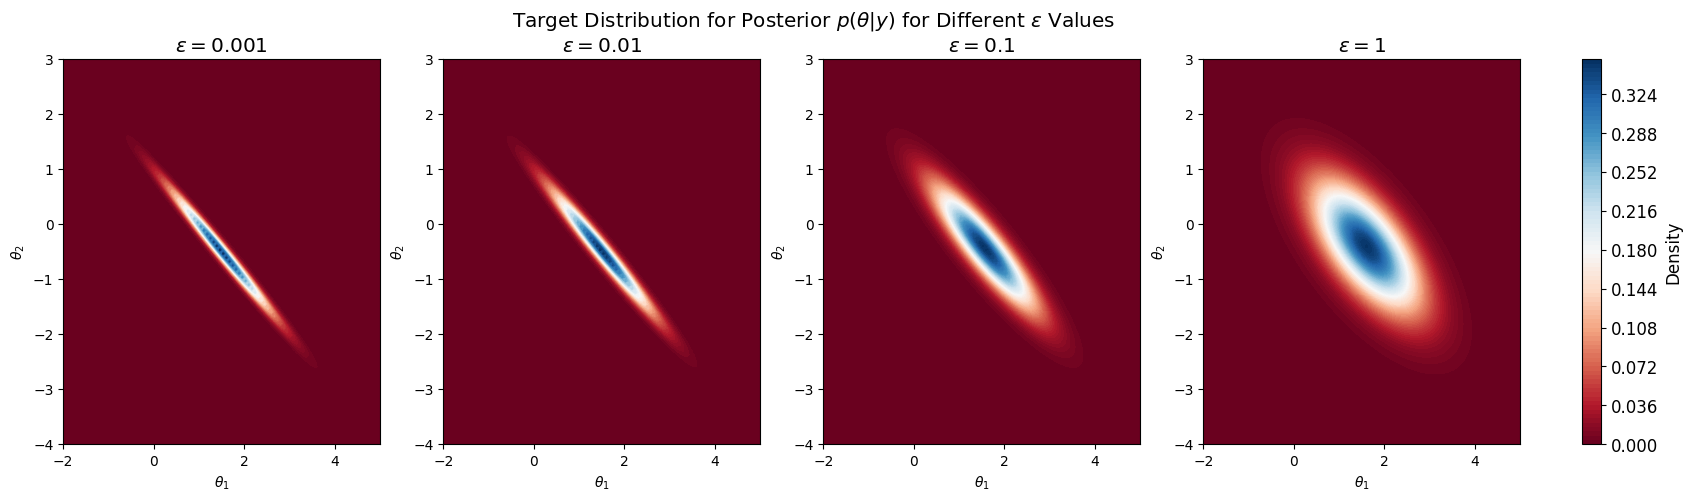

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Define grid for contour plot
x_bb = np.linspace(-2, 5, 100)
y_bb = np.linspace(-4, 3, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plt.rcParams.update({'font.size': 12})  # Set font size

for i in df_post.index:
    eps = df_post['Epsilon'][i]
    post_mean = df_post['Posterior Mean'][i]
    post_var = df_post['Posterior Variance'][i]

    # rv = multivariate_normal(mean=mu_theta, cov=Sigma)
    rv = multivariate_normal(mean=post_mean, cov=post_var)

    # Evaluate the posterior density on the grid
    pos = np.dstack((X_bb, Y_bb))
    Z_bb = rv.pdf(pos)

    # Plot the contour
    ax = axes[i]
    cnt = ax.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
    ax.set_title(f'$\\epsilon = {eps:.3g}$')
    ax.set_xlabel('$\\theta_1$')
    ax.set_ylabel('$\\theta_2$')

# Add colorbar
fig.colorbar(cnt, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, label='Density')
plt.suptitle('Target Distribution for Posterior $p(\\theta | y)$ for Different $\\epsilon$ Values')
plt.show()


We have that very roughly:
$$
p(\theta\mid y) = \mathcal{N}(y; 
\begin{pmatrix}1.6 \\[4pt] -0.4 \end{pmatrix}, 
\begin{pmatrix}0.6 & -0.4 \\[4pt]-0.4 & 6\end{pmatrix}
)
$$

For larger epsilon, $\theta_1$ gets larger, and $\theta_2$ gets smaller. 

The variance for each $\theta_i$ is also larger, with less negative correlation

Visually we can see that as epsilon gets larger, the posterior distribution 
becomes closer to a circle (or 2-dim gaussian), whereas for small epsilon, the posterior distribution 
resembles closer to the line of $ y = -x+1$

### 1.3

I use $x$ to denote $\theta$, and use $x_s$ to denote a new state,
(equivalent to $\theta'$)
for simplicity. 
My RWMH algorithm follows these steps:

1. **Initialize** at $x_0 = (0, 0)$, **fix** $\sigma_{\text{RW}}$
2. For each iteration:
   - **Propose** a new state under 
   $q(\theta' | \theta_{n-1}) = \mathcal{N}(\theta_{n-1}, 
   \sigma_{\text{rw}}) $
     $$ x_s = x_{n-1} + \sigma_{\text{rw}} \cdot \mathcal{N}(0, I) $$
   - **Compute acceptance probability**:  
     $$ a = \min\left(1, \frac{\pi(x_s)}{\pi(x_{n-1})} \right) $$
   - **Accept or reject**:
     - With probability $a$, set $x_n = x_s $.
     - Otherwise, set $ x_n = x_{n-1} $.

I set $\sigma_{\text{rw}} = 0.2 $.
If it's too small, proposals are close to the current state → slow exploration.  
Otherwise if too large, proposals often land in low-probability regions → high rejection rate.


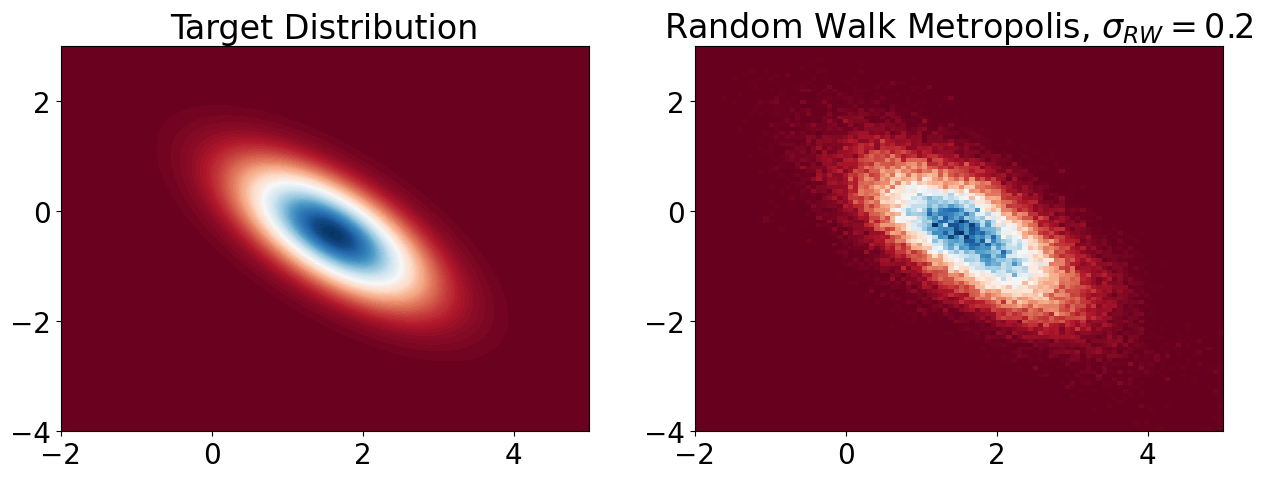

In [3]:
# Set random seed
rng = np.random.default_rng(24)

# Load posterior mean and variance
post_mean = df_post['Posterior Mean'][3]
post_var = df_post['Posterior Variance'][3]
rv = multivariate_normal(mean=post_mean, cov=post_var)

# Define log of the new target distribution
def logPi(x):
    return rv.logpdf(x)

# MCMC Sampling
def RWMH(logPi, sigma_rw = 0.5, N = 100000, burnin = 1000):
    samples_RW = np.zeros((2, N))
    samples_RW[:, 0] = np.array([0, 0])

    # Random Walk Metropolis-Hastings Algorithm
    for n in range(1, N):
        # Proposal sample from Gaussian random walk
        x_s = samples_RW[:, n-1] + sigma_rw * rng.normal(size=2)
        
        # Metropolis-Hastings acceptance step
        u = rng.uniform(0, 1)
        if np.log(u) < logPi(x_s) - logPi(samples_RW[:, n-1]):
            samples_RW[:, n] = x_s
        else:
            samples_RW[:, n] = samples_RW[:, n-1]
    return samples_RW

burnin = 1000
samples_RW = RWMH(logPi, sigma_rw = 0.2, burnin=burnin)

# Visualization
x_bb = np.linspace(-2, 5, 100)
y_bb = np.linspace(-4, 3, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
pos = np.dstack((X_bb, Y_bb))
Z_bb = rv.pdf(pos)

plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 20})

# Contour plot of target distribution
plt.subplot(1, 2, 1)
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution')

# Histogram of sampled points
plt.subplot(1, 2, 2)
plt.hist2d(samples_RW[0, burnin:], samples_RW[1, burnin:], 
           100, cmap='RdBu', range=[[-2, 5], [-4, 3]], density=True)
plt.title('Random Walk Metropolis, $\\sigma_{RW} = 0.2$')
plt.show()

### 1.4

In [4]:
import statsmodels.api as sm

sigma_values = np.logspace(-4, np.log10(4), num=10)

acf_results = {} # Store results
samples_results = {}

for sigma_rw in sigma_values:
    samples_RW = RWMH(logPi, sigma_rw=sigma_rw, burnin=burnin)
    
    # Store results
    acf_results[sigma_rw] = sm.tsa.acf(samples_RW[0, burnin:], nlags=50)
    samples_results[sigma_rw] = samples_RW

# Find the best sigma_rw (lowest autocorrelation at lag 1)
best_sigma_rw = min(acf_results, key=lambda s: acf_results[s][1])
samples_RW_best = samples_results[best_sigma_rw]
print(f'Best sigma_rw: {best_sigma_rw}')


Best sigma_rw: 1.2323100555166684


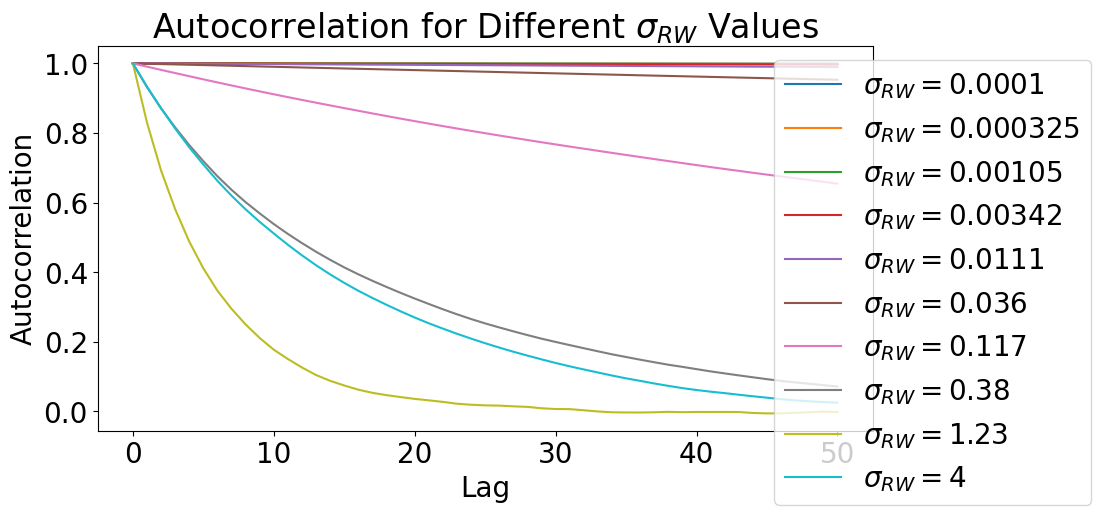

In [5]:
# plot acf for each sigma_rw
fig, ax = plt.subplots(figsize=(10, 5))
for sigma_rw in sigma_values:
    ax.plot(acf_results[sigma_rw], label=f'$\\sigma_{{RW}} = {sigma_rw:.3g}$')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation for Different $\\sigma_{RW}$ Values')
# smaller legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

We notice that sig = 1.23 decays the fastest in terms of acf, dropping to near 0 within 30 lags.

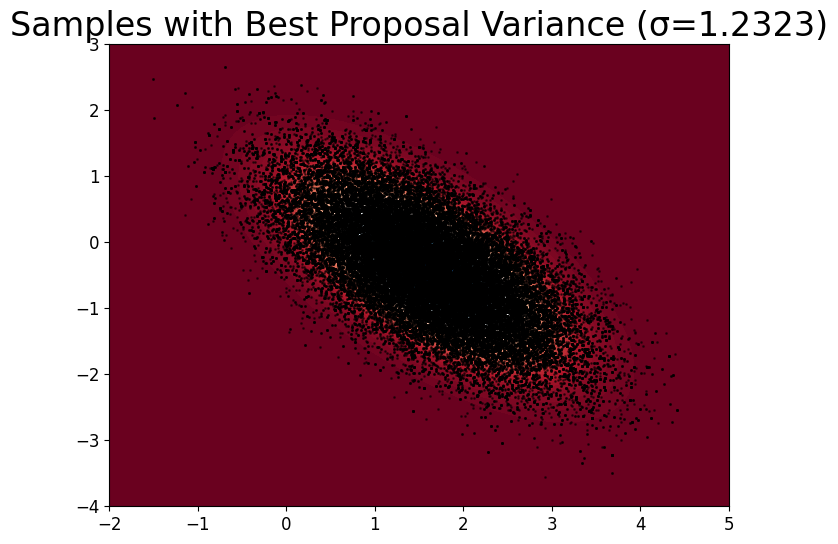

In [6]:
# Visualization
x_bb = np.linspace(-2, 5, 100)
y_bb = np.linspace(-4, 3, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
pos = np.dstack((X_bb, Y_bb))
Z_bb = rv.pdf(pos)

plt.figure(figsize=(8, 6))
plt.tick_params(axis='y', labelsize=12) 
plt.tick_params(axis='x', labelsize=12)
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.scatter(samples_RW_best[0, burnin:], samples_RW_best[1, burnin:],
             s=1, color='black', alpha=0.5)
plt.title(f'Samples with Best Proposal Variance (σ={best_sigma_rw:.4f})')
plt.xlim(-2, 5)
plt.ylim(-4, 3)
plt.show()

We report that the best variance is $ 1.2323^2 $ ,under which the RWMH basically covers all the high-probability region

### 1.5

Best epsilon: 1.0


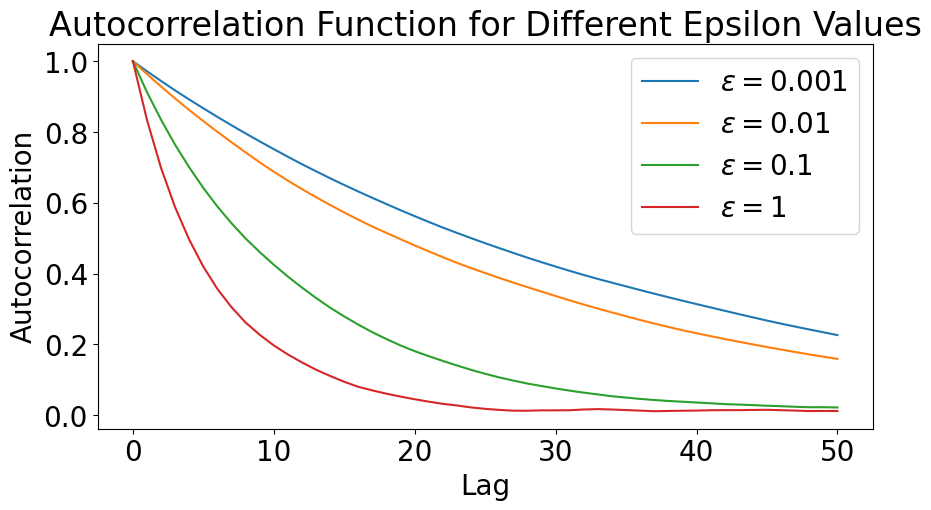

In [7]:
sigma_rw = 1.2323

fig, ax = plt.subplots(figsize=(10, 5))
acf_eps = {}

for i in df_post.index:
    eps = df_post['Epsilon'][i]
    post_mean = df_post['Posterior Mean'][i]
    post_var = df_post['Posterior Variance'][i]

    rv = multivariate_normal(mean=post_mean, cov=post_var)
    
    samples_RW = RWMH(logPi= lambda x, rv=rv: rv.logpdf(x),
                       sigma_rw=sigma_rw)

    Z_bb = rv.pdf(pos) # Evaluate the posterior density on the grid
        
    # Store results
    acf_eps[eps] = sm.tsa.acf(samples_RW[0, burnin:], nlags=50)

    ax.plot(acf_eps[eps], label=f'$\\epsilon = {eps:.3g}$')

# Find the best eps (lowest autocorrelation at lag 1)
best_eps = min(acf_eps, key=lambda e: acf_eps[e][1])
print(f'Best epsilon: {best_eps}')

ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function for Different Epsilon Values")
ax.legend()
plt.show()



We clearly observe that eps=1 leads to fastest convergence of ACF, with autocorr reaching near 0 within 30 lags.

$\epsilon=1$ is the best out of the four epsilons make sense, because it maximizes the likelihood.

Under $\epsilon=1$, the posterior mean for $\theta$ is [1.6016, -0.3984], cloest to the mean (and maximum) of (2, 0) for $\theta$ under the prior, out of the four.

We also note that expected x under the prior (without any data) is 
$$
Cm = \begin{pmatrix}1 & 1\\[4pt] 1 & 1.01\end{pmatrix}
\begin{pmatrix}2 \\[4pt] 0\end{pmatrix} = \begin{pmatrix}2 \\[4pt] 2\end{pmatrix} 
$$

And the information we have about y under prior of $x, \theta$ is

$$
A\begin{pmatrix}2 \\[4pt] 2\end{pmatrix}  = \begin{pmatrix}1 & 0 \\[4pt]\varepsilon & 0\end{pmatrix}\begin{pmatrix}2 \\[4pt] 2\end{pmatrix} = 
\begin{pmatrix}2 \\[4pt] 2 \epsilon \end{pmatrix} 
$$

$$
y \sim \mathcal{N}\left(\begin{pmatrix}2 \\[4pt] 2 \epsilon \end{pmatrix} ,
 \begin{pmatrix}\epsilon & 0\\[4pt] 0 & \epsilon \end{pmatrix} \right)
$$

Given that y is observed to be (1, 1), this suggests that we want a larger $\epsilon$ to account for the difference of data to the prior mean, and we have information that two entries of y are identical, which suggest that $2\epsilon$ should be close to 2

This leads us to choose $\epsilon=1$

### 1.6


We know that
$$
p(y \mid \theta)
=
\int_x p(y \mid x)\; p(x \mid \theta) dx
$$

$$
= \int_x p(y \mid x)\; 
\frac{p(x \mid \theta)}{q(x \mid \theta)} q(x \mid \theta) dx
$$

$$
= E_{q(x \mid \theta)} \;  \left[p(y \mid x)\;  
\frac{p(x \mid \theta)}{q(x \mid \theta)}\right]
$$

Where $ q(x \mid \theta) $ is our proposal

Hence we can sample $\{X_i\}_{i=1}^N$ from $ q(x \mid \theta) $,
then compute 
$$
\frac{1}{N} \sum_{i=1}^N
p(y \mid X_i)\;  \frac{p(X_i \mid \theta)}{q(X_i \mid \theta)}
$$
as an unbiased estimator of $p(y \mid \theta)$

We can also denote our estimator as
$$
\sum_{i=1}^N w_i \; p(y \mid X_i)
$$

Where
$ w_i = \frac{1}{N} \frac{p(X_i \mid \theta)}{q(X_i \mid \theta)} $ 
is the self-normalizing weight

### 1.7



In [8]:
# We re-define parameters again
epsilon = 1
theta = [0, 0]
y = [1, 1]

m = np.array([2, 0])
Q = np.array([[0.01, 0], [0, 0.01]])
P = np.array([[1, 0], [0, 1]])
C = np.array([[1, 1], [1, 1.01]])
A = np.array([[1, 0], [epsilon, 0]])
R = np.array([[epsilon, 0], [0, epsilon]])

In [9]:
def log_p_y_given_theta(y, theta):
    # true log density of y given theta
    mean = np.dot(A, np.dot(C, theta))
    cov = np.dot(A, np.dot(Q, A.T)) + R
    diff = y - mean
    return (-0.5 * np.dot(diff.T, np.linalg.inv(cov)).dot(diff) 
            - 0.5 * np.log(np.linalg.det(2 * np.pi * cov)))

def log_p_x_given_theta(x, theta):
    diff = x - np.dot(C, theta)
    return (-0.5 * np.dot(diff.T, np.linalg.inv(Q)).dot(diff) 
            - 0.5 * np.log(np.linalg.det(2 * np.pi * Q)))

def log_p_y_given_x(y, x):
    diff = y - np.dot(A, x)
    return (-0.5 * np.dot(diff.T, np.linalg.inv(R)).dot(diff) 
            - 0.5 * np.log(np.linalg.det(2 * np.pi * R)))

def log_p_theta(theta):
    diff = theta - m
    return (-0.5 * np.dot(diff.T, np.linalg.inv(P)).dot(diff) 
            - 0.5 * np.log(np.linalg.det(2 * np.pi * P)))

In [10]:
def logq(x, sig): # log-density of the proposal
    # proposal N(0, sig^2) in 2D
    return (- x[0]**2/(2 * sig**2) - x[1]**2/(2 * sig**2) 
            - np.log(2 * np.pi * sig**2))

# Self-normalised importance sampling of p(y|theta) 
def SNIS_for_loop(N, sig, theta=[0, 0]):
    '''Classical SNIS using a for loop'''
    # we used that y is fixed
    x_samples = rng.normal(0, sig, (N, 2)) # propose x
    logw = np.zeros(N) # log-weights
    phi_X = np.zeros(N)
    for i in range(N):
        logw[i] = (log_p_x_given_theta(x_samples[i, :], theta)
                    - logq(x_samples[i, :], sig))
        phi_X[i] = np.exp(log_p_y_given_x(y, x_samples[i, :]))
    logw = logw - np.max(logw) # to avoid numerical issues
    w = np.exp(logw)/np.sum(np.exp(logw)) # normalising the weights

    return np.dot(w, phi_X)

We also give a faster IS algorithm below, where we use vectorization to avoid the time-consuming for loop

In particular, since we know that $ \epsilon = 1$ 
and $ y = (1, 1) $ are fixed, 
we have the likelihood

$$
p(y \mid x) = \mathcal{N}(y; Ax, R)
= \mathcal{N}((1, 1); (x_1, x_1), I_2)
$$

We implement this in a vectorized way below


In [11]:
def p_y_given_x(x):
    """Compute the density of N((1,1); (x1, x1), I_2) for given x (N,2)."""
    mu = np.array([1, 1])  # Mean
    norm_const = 1 / (2 * np.pi)  # (1 / sqrt((2π)^2 * det(I_2)))
    diff = x - mu  # (N,2)
    exp_term = np.exp(-0.5 * np.sum(diff**2, axis=1))  # (N,)
    return norm_const * exp_term  # (N,)

def q(x, sig):
    # x has shape (N, 2)
    return multivariate_normal.pdf(x, mean=np.zeros(2), cov=sig**2 * np.eye(2))

def p_x_given_theta(x, theta):
    # x has shape (N, 2)
    return multivariate_normal.pdf(x, mean=np.dot(C, theta), cov=Q)


In [12]:
# we provide a new definition of IS with vectorization
def SNIS(N, sig, theta=[0, 0]):
    x_samples = rng.normal(0, sig, (N, 2)) # propose x
    
    # y | x likelihood
    phi_X = p_y_given_x(x_samples)
    # element wise division, w is (N, )
    w = p_x_given_theta(x_samples, theta) / q(x_samples, sig)
    return np.mean(w * phi_X)

# check result with SNIS with example run with sig=0.1
K, sig_ = 10000, 0.1
phi_SNIS = SNIS_for_loop(K, sig_  )
print('SNIS for loop:', phi_SNIS)
phi_SNIS_vec = SNIS(K, sig_)
print('SNIS vectorized:', phi_SNIS_vec)
true_lik = np.exp(log_p_y_given_theta(y, theta)) # true p(y|theta)
print('True likelihood:', true_lik)

SNIS for loop: 0.05907423628644317
SNIS vectorized: 0.058690530565830304
True likelihood: 0.05912091432281943


We can see that all three are sufficiently close,
and we will use the vectorized SNIS from now on.

In [13]:
# Relative Absolute Error
def RAE(est):
    return np.abs(est - true_lik)/true_lik

We tune sigma by computing the RAE for running SNIS under different sigma, 
with K = $10^4$ and averaging each sigma with 10 simulations

Text(0.5, 1.0, 'Average RAE for Different Sigma IS Values')

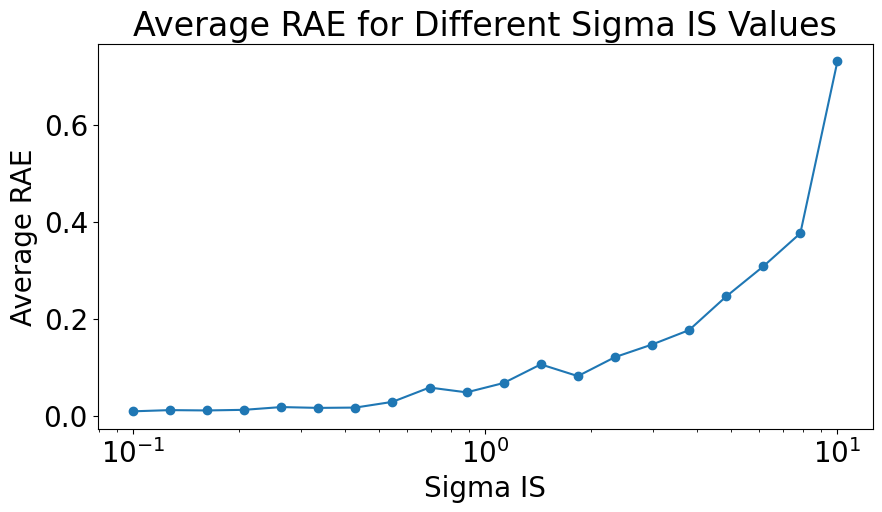

In [14]:
sig_vals = np.logspace(-1, 1, num=20)
num_runs = 10
K = 10000
avg_RAE = [] # Store results
for sig in sig_vals:
    RAE_values = []
    for _ in range(num_runs):
        est = SNIS(K, sig)  # Run SNIS
        RAE_values.append(RAE(est))  # Compute RAE
    
    avg_RAE.append(np.mean(RAE_values))  # Store average RAE

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sig_vals, avg_RAE, 'o-')
plt.xscale('log')
plt.xlabel('Sigma IS')
plt.ylabel('Average RAE')
plt.title('Average RAE for Different Sigma IS Values')

For sigma larger than 1, we can clearly see that the RAE gets a lot larger. 

To choose the best sigma within [0.1, 1], we specifically plot sigma=0.2, 0.5 and 1.0 below

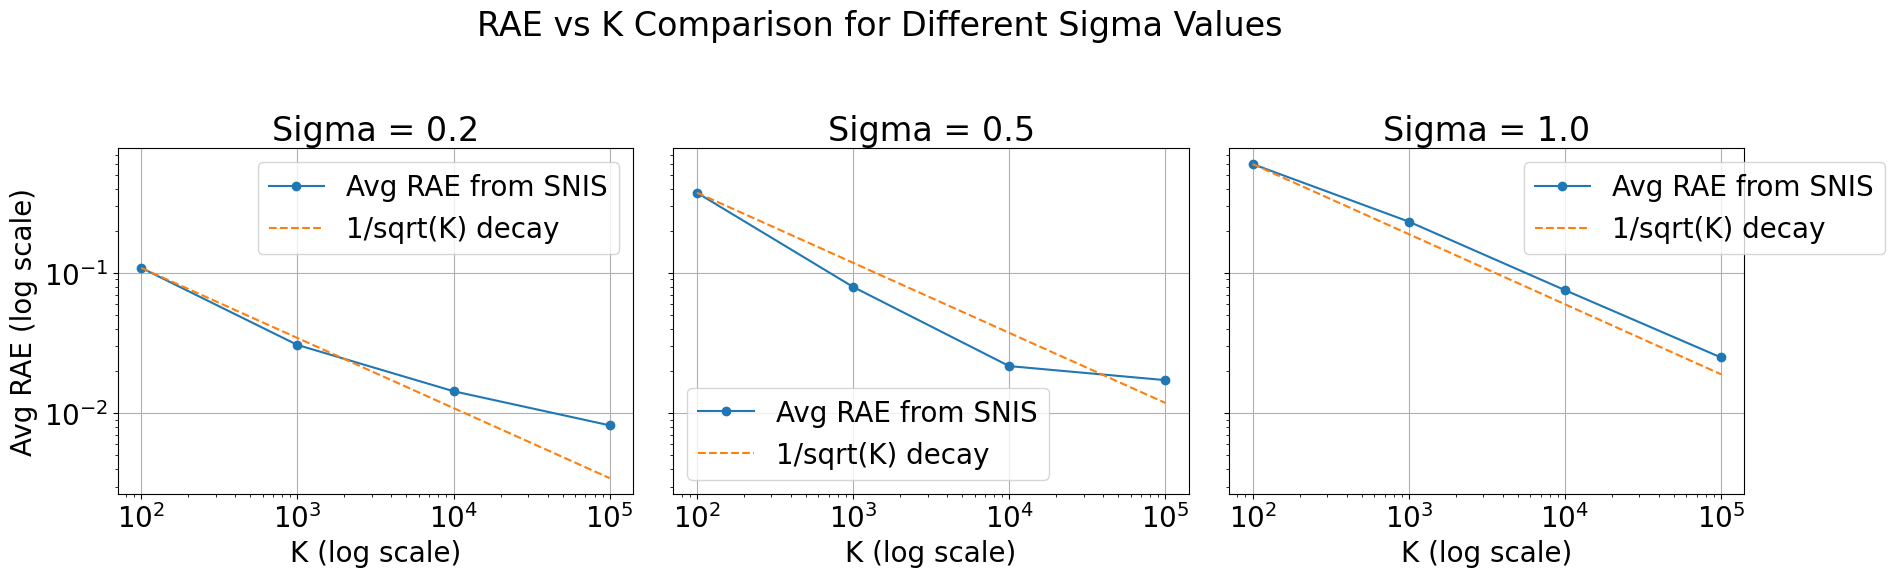

In [15]:
sigma_values = [0.2, 0.5, 1.0]
K_values = np.logspace(2, 5, num=4, dtype=int)  # K from 10^2 to 10^5
num_runs = 10  # 10 MCMC runs per K

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, sigma in enumerate(sigma_values):
    avg_RAE = []  # Store results for this sigma
    
    for K in K_values:
        RAE_values = []
        
        for _ in range(num_runs):
            est = SNIS(K, sigma)  # Run SNIS
            RAE_values.append(RAE(est))  # Compute RAE
        
        avg_RAE.append(np.mean(RAE_values))  # Store average RAE

    # Compute reference decay curve
    # we choose a constant at the front to match value at K = 1e2
    decay_curve = 1 / np.sqrt(K_values) * avg_RAE[0] * 10

    # Plot results in corresponding subplot
    ax = axes[i]
    ax.loglog(K_values, avg_RAE, label="Avg RAE from SNIS", marker='o')
    ax.loglog(K_values, decay_curve, label="1/sqrt(K) decay", linestyle="--")
    ax.set_xlabel("K (log scale)")
    ax.set_title(f"Sigma = {sigma}")
    ax.grid()
    if i == 0:
        ax.set_ylabel("Avg RAE (log scale)")
    ax.legend()

# Adjust layout and show plot
plt.suptitle("RAE vs K Comparison for Different Sigma Values")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()


From the plots, we can see that sigma=1 gives the cloest decay to 1/sqrt(K)

### 1.8

In our case we have

$$
p(\theta \mid y) \propto 
p(\theta) \; p(y \mid \theta)
$$

where we assume
$$
p(y \mid \theta)
=
\int_x p(y \mid x)\; p(x \mid \theta) dx
$$

$$
= \int_x p(y , x \mid \theta) dx
$$
is intractable, and can be replaced by the IS estimator 
$ \hat{p}(y|\theta) $ as described above (in 1.6 & 1.7)

We know $ p(y , x \mid \theta) $ can be computed pointwise
for any $ x, \theta $, since $ y $ is the fixed data.

Hence we can plug the IS estimator 
$ \hat{p}(y|\theta) $
 into the MH ratio to obtain the PMMH:

1. **Initialize** at $\theta_0 = (0, 0)$, 
**fix** $\sigma_{\text{MH}}$ and $\sigma_{\text{IS}}$

2. For each iteration:
   - **Propose** a new state under 
   $q(\theta' | \theta_{n-1}) = \mathcal{N}(\theta_{n-1}, \sigma_{\text{rw}}) $

    $$ \theta' = \theta_{n-1} + \sigma_{\text{MH}} \cdot \mathcal{N}(0, I) $$
   - **Run IS to compute likelihood under $\theta'$**:
   $\hat{p}(y|\theta')$ using the algo described above

   - **Compute acceptance probability**:  
    $$ 
    \alpha(\theta_{n-1}, \theta') = \min \left( 1, \frac{\hat{p}(y|\theta') p(\theta')(\theta_{n-1} | \theta')}{\hat{p}(y|\theta_{n-1}) p(\theta_{n-1}) q(\theta' | \theta{n-1})} \right)
    $$

    Note if we are using symmetric proposal 
    $ q(\theta' | \theta_{n-1}) = q(\theta_{n-1} | \theta')$,
    then the ratio becomes
    $$ 
    \alpha(\theta_{n-1}, \theta') = \min \left( 1, \frac{\hat{p}(y|\theta') p(\theta')}{\hat{p}(y|\theta_{n-1}) p(\theta_{n-1}) } \right)
    $$

   - **Accept or reject**:
     - With probability $a$, set $\theta_n = \theta' $.
     - Otherwise, set $ \theta_n = \theta_{n-1} $.


### 1.9


After tuning, we find out that `sig_IS=1, sig_MH=0.2` leads to the best result

/var/folders/fd/vr4zygtx6jxftqb9dm5hvstw0000gn/T/ipykernel_91631/2646886319.py:20: RuntimeWarning: divide by zero encountered in log
  IS_lik_new = np.log(SNIS(K, sig_IS, theta=x_s))


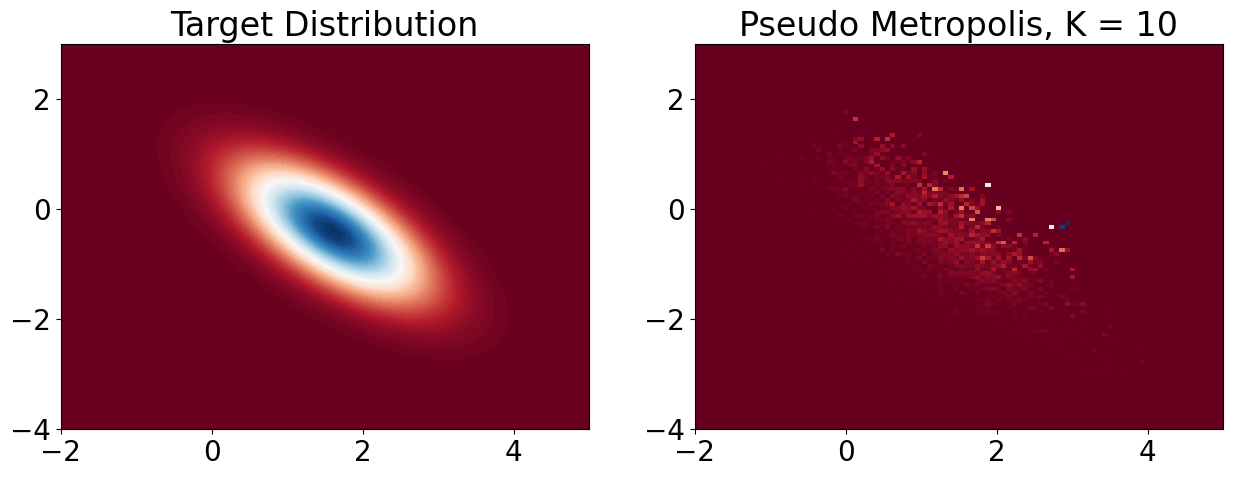

array([[ 2.69124794,  2.69124794,  2.69124794, ...,  0.77146774,
         0.77146774,  0.77146774],
       [-0.38394132, -0.38394132, -0.38394132, ...,  0.08873006,
         0.08873006,  0.08873006]])

In [16]:
def PMMH(logPi, sig_IS, sig_MH, K = 10, 
         N = 100000, burnin = 5000, use_for_loop=False):
    # logPi is the prior logp(theta)

    sample_MH = np.zeros((2, N))
    sample_MH[:, 0] = np.array([0, 0])
    if use_for_loop:
        IS_lik = np.log(SNIS_for_loop(K, sig_IS, theta=sample_MH[:, 0]))
    else:
        IS_lik = np.log(SNIS(K, sig_IS, theta=sample_MH[:, 0]))

    for n in range(1, N):
        # Proposal sample from Gaussian random walk
        x_s = sample_MH[:, n-1] + sig_MH * rng.normal(size=2)

        # IS estimate of the log likelihood
        IS_lik_new = log_p_y_given_theta(y, x_s)
        # print('true', IS_lik_new)

        IS_lik_new = np.log(SNIS(K, sig_IS, theta=x_s))
        # print(IS_lik_new)
        ratio = (IS_lik_new - IS_lik + logPi(x_s) - logPi(sample_MH[:, n-1]))

        # Metropolis-Hastings acceptance step
        u = rng.uniform(0, 1)
        if np.log(u) < ratio:
            sample_MH[:, n] = x_s
            IS_lik = IS_lik_new
        else:
            sample_MH[:, n] = sample_MH[:, n-1]

    return sample_MH[:, burnin:]

acf_K = {} # Store acf 
def plot_MH(k, sig_IS, sig_MH, use_for_loop=False):
    samples_MH = PMMH(log_p_theta, sig_IS=sig_IS, sig_MH=sig_MH,
                       K = k, N = 100000, burnin=5000, use_for_loop=use_for_loop)
    acf_K[k] = sm.tsa.acf(samples_MH[0, :], nlags=50)
    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 20})

    # Contour plot of target distribution
    plt.subplot(1, 2, 1)
    plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
    plt.title('Target Distribution')

    # Histogram of sampled points
    plt.subplot(1, 2, 2)
    plt.hist2d(samples_MH[0, :], samples_MH[1, :], 
            100, cmap='RdBu', range=[[-2, 5], [-4, 3]], density=True)
    plt.title(f'Pseudo Metropolis, K = {k}')
    plt.show()
    return samples_MH

plot_MH(10, 1, 0.2, use_for_loop=True)

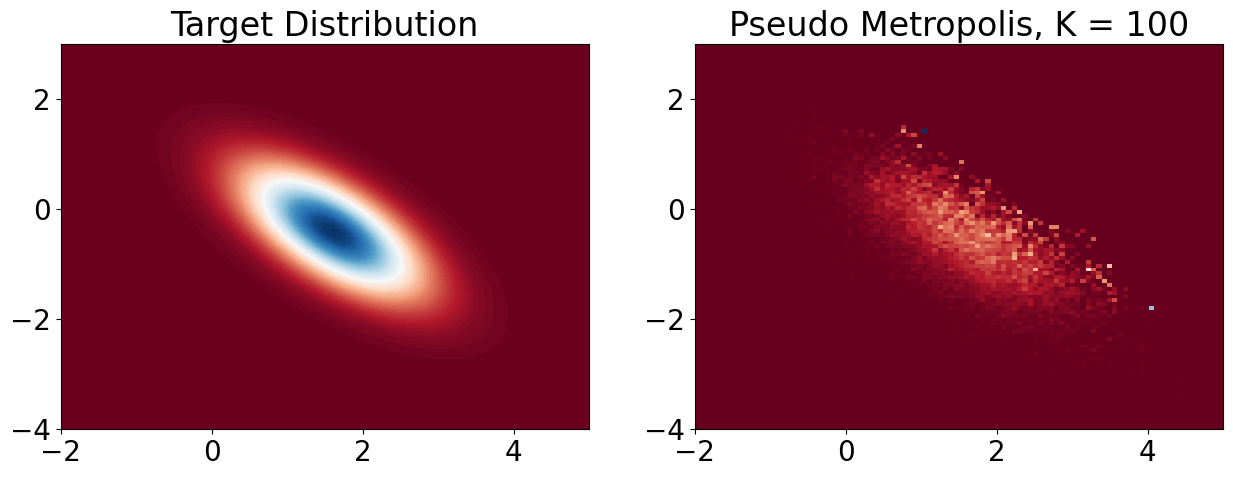

array([[ 2.23551654,  2.23551654,  2.05955911, ...,  1.75197883,
         1.75197883,  1.75197883],
       [-1.46745188, -1.46745188, -1.67482059, ..., -0.97417365,
        -0.97417365, -0.97417365]])

In [17]:
plot_MH(100, sig_IS=1, sig_MH=0.2, use_for_loop=False)

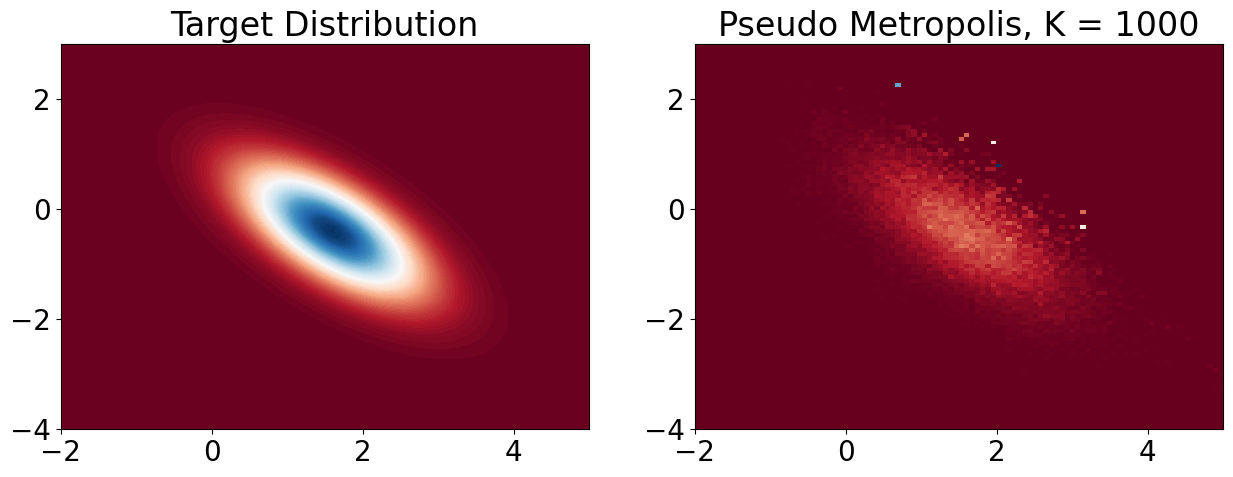

In [18]:
samples_MH = plot_MH(1000, sig_IS=1, sig_MH=0.2, use_for_loop=False)

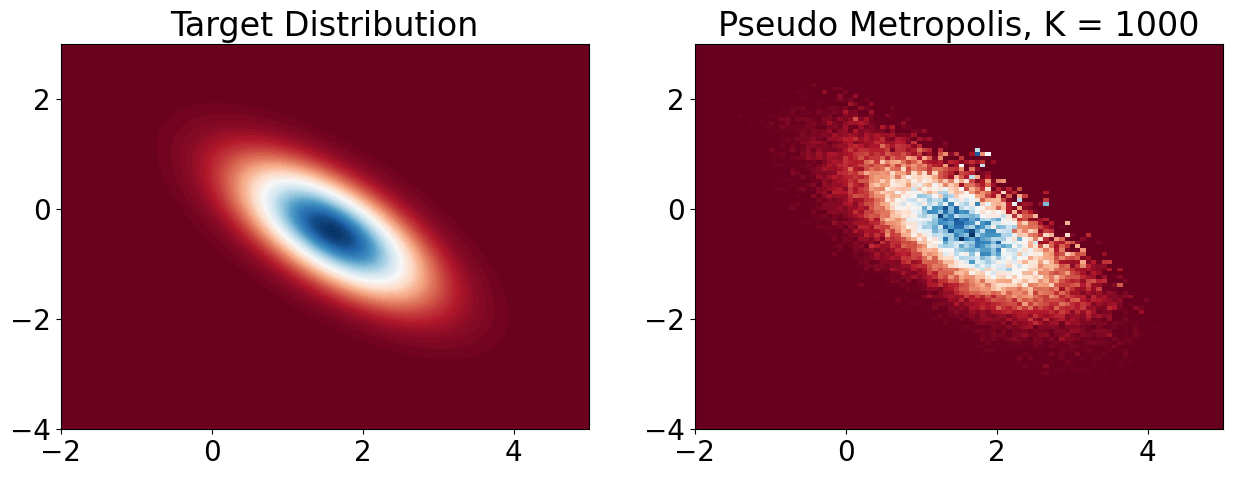

In [19]:
samples_MH = plot_MH(1000, sig_IS=1, sig_MH=0.2, use_for_loop=False)

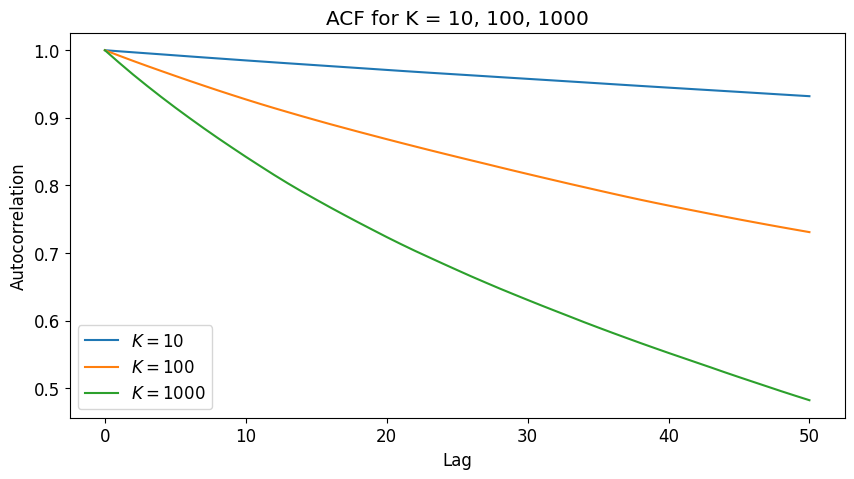

In [20]:
# autocorr
plt.rcParams.update({'font.size': 12})  # Set font size
fig, ax = plt.subplots(figsize=(10, 5))
acf_eps = {}

for k in acf_K.keys():
    ax.plot(acf_K[k], label=f'$K = {k}$')
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("ACF for K = 10, 100, 1000")
ax.legend()
plt.show()


We can clearly see that larger K provides less correlated samples, with a clearly correlation between large K and faster decay in ACF.

We can also see from the three plots that large K provides better sample closer to the true target distribution, despite same N.

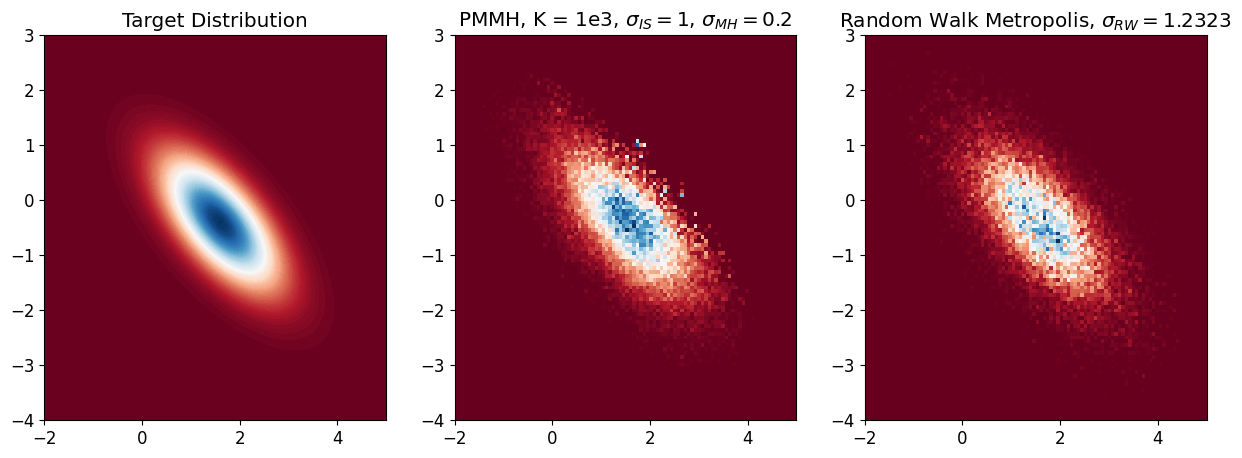

In [21]:
# compare K = 1000 with RWMH
plt.rcParams.update({'font.size': 12})  # Set font size
plt.figure(figsize=(15, 5))

# Contour plot of target distribution
plt.subplot(1, 3, 1)
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution')

# Histogram of sampled points
plt.subplot(1, 3, 2)
plt.hist2d(samples_MH[0, :], samples_MH[1, :], 
        100, cmap='RdBu', range=[[-2, 5], [-4, 3]], density=True)
plt.title('PMMH, K = 1e3, $\\sigma_{IS} = 1$, $\\sigma_{MH} = 0.2$')

plt.subplot(1, 3, 3)
plt.hist2d(samples_RW_best[0, burnin:], samples_RW_best[1, burnin:],
                100, cmap='RdBu', range=[[-2, 5], [-4, 3]], density=True)
plt.title('Random Walk Metropolis, $\\sigma_{RW} = 1.2323$')
plt.show()

The RWMH is slightly better than the PMMH sampler. This is because we need to use IS to estimate the likelihood, which is given in the RWMH.

Both have samples covering the majority of the high-density areas in the target, though random walk could cover the central part at a higher density, as we can see the central area around the posterior mean is slightly more blue in the RWMH than the PMMH. 

# 2
### 2.1

For fixed T, given $ m_0 = 0, P_0 = 1, A = 0.9,
Q = 0.01, H = 1, R = 0.1 $

We simulate $ x_0 \sim \mathcal{N}(m_0, P_0) $

for t = 1, 2, .., T:  
- Simulate $ x_t \sim \mathcal{N}(A x_{t-1}, Q) $  
- Simulate $ y_t \sim \mathcal{N}(H x_{t}, R) $  

return $ x_{0:T}, y_{1:T} $



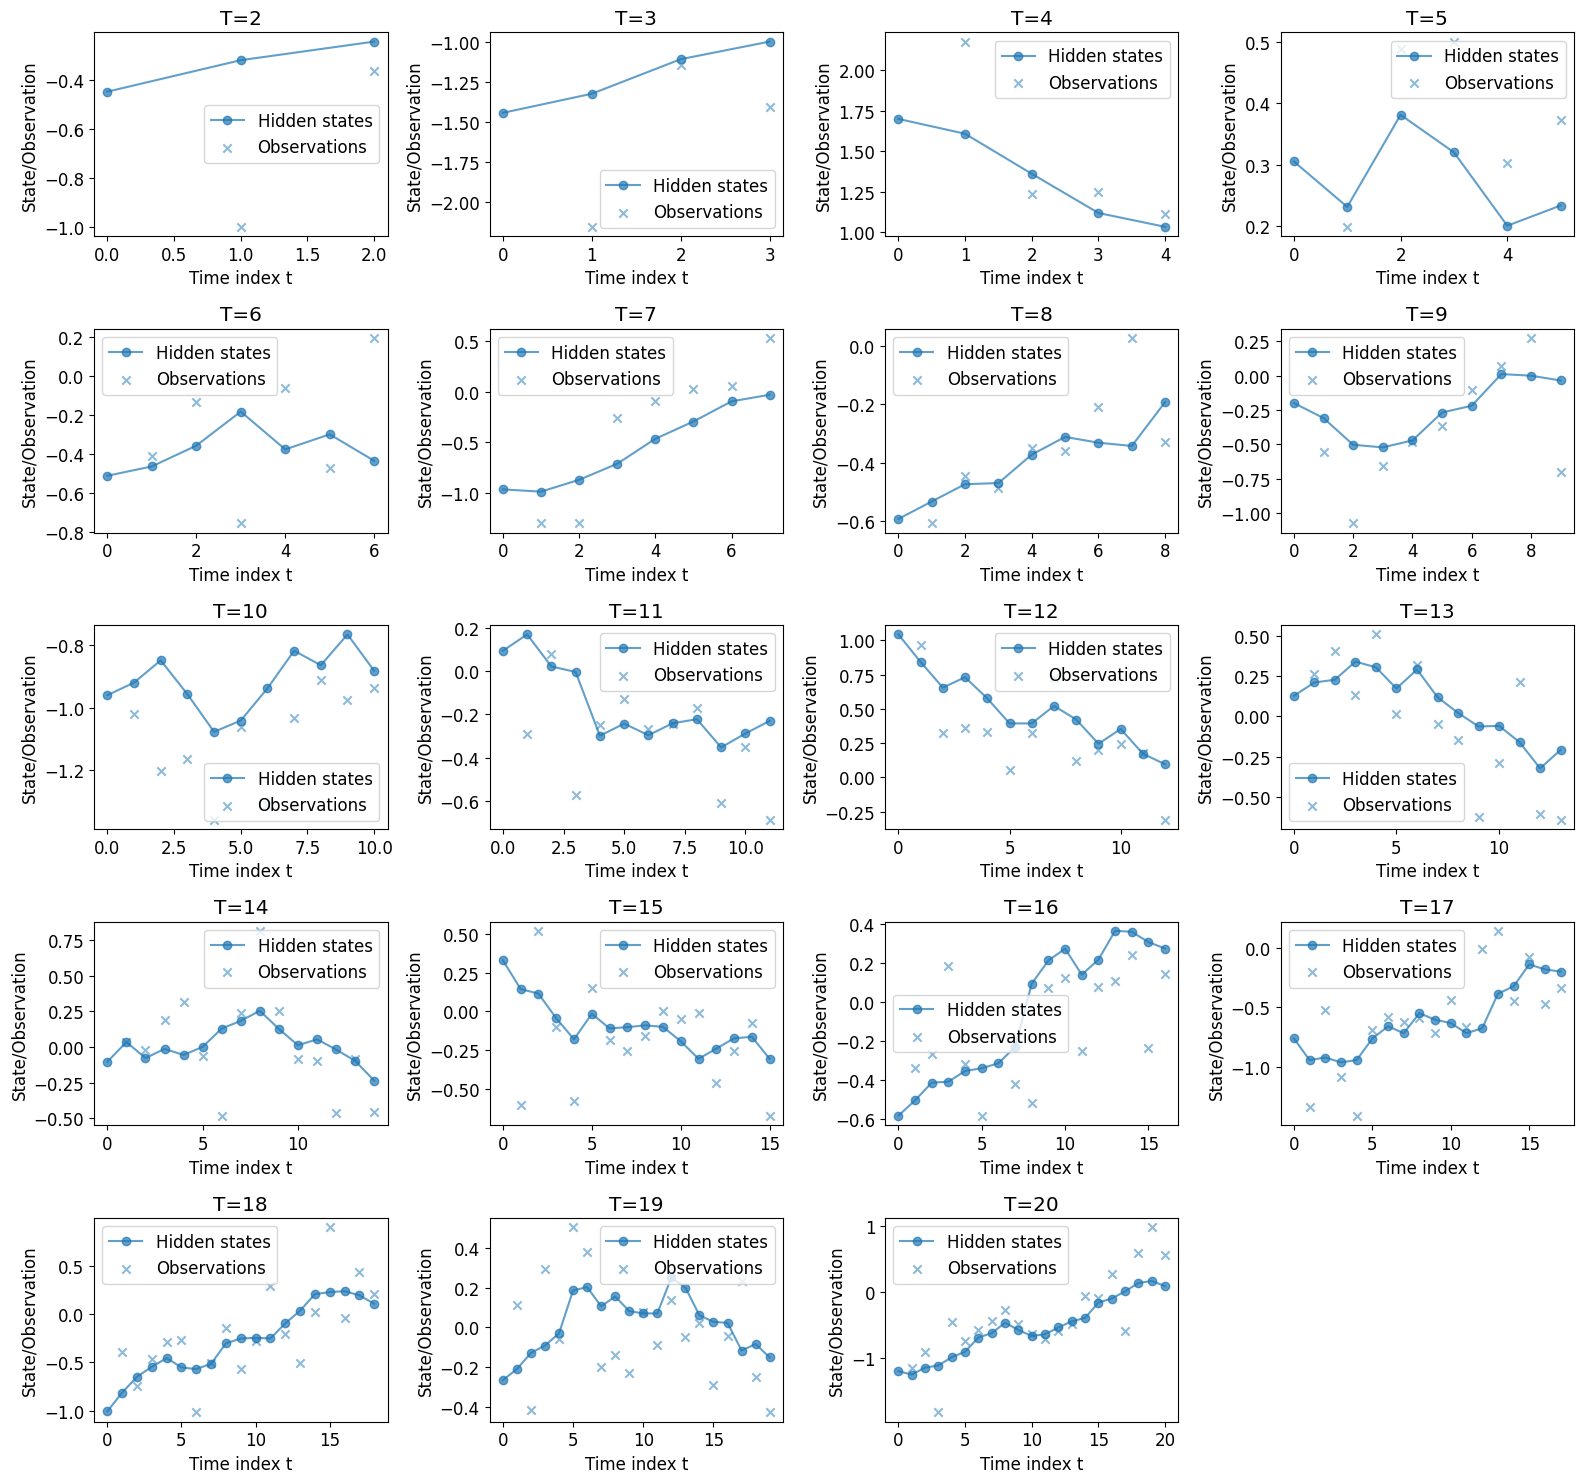

In [22]:

plt.rcParams.update({'font.size': 12})  # Set font size

def simulate_hmm(T, m0=0, P0=1, A=0.9, Q=0.01, H=1, R=0.1):
    """Simulate data from a linear-Gaussian HMM"""
    # Initialize state sequence
    x = np.zeros(T+1)
    y = np.zeros(T)
    
    # Sample initial state
    x[0] = np.random.normal(m0, np.sqrt(P0))
    
    # Generate state and observation sequences
    for t in range(1, T+1):
        x[t] = np.random.normal(A * x[t-1], np.sqrt(Q))
        y[t-1] = np.random.normal(H * x[t], np.sqrt(R))
    
    return x, y

datasets = {} # save for each T

# Simulate and plot for T = 2 to 20

# Initialize figure with 5 rows and 4 columns
fig, axes = plt.subplots(5, 4, figsize=(16, 15))
axes = axes.flatten()  # Flatten to easily iterate

for idx, T in enumerate(range(2, 21)):
    ds = {}
    x, y = simulate_hmm(T)
    
    ax = axes[idx]  # Select corresponding subplot

    # x has an extra x_0, so we use range(T+1)
    ax.plot(range(T+1), x, label="Hidden states", 
            alpha=0.7, linestyle='-', marker='o')

    ax.scatter(range(1, T+1), y, alpha=0.5, 
               marker='x', label="Observations")

    ax.set_title(f"T={T}")
    ax.set_xlabel("Time index t")
    ax.set_ylabel("State/Observation")
    ax.legend()

    # Save dataset
    ds[0] = x
    ds[1] = y
    datasets[T] = ds

# Remove any empty subplots (if necessary)
for i in range(len(range(2, 21)), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### 2.2

Since we have the same setup from lecture notes:
$$
p(x_0) = \mathcal{N}(x_0; m_0, P_0)
$$

$$
\tau(x_n | x_{n-1}) = \mathcal{N}(x_n; A x_{n-1}, Q)
$$

$$
g(y_n | x_n) = \mathcal{N}(y_n; H x_n, R)
$$


With Kalman filter, we can obtain $ \pi_n(x_n | y_{1:n}) = \mathcal{N}(x_n ; m_n, P_n) , n \leq T$  
so we know the filtering mean $ m_t = E [ x_t | y_{1:t} ]$
for each $ t = 1, 2, \dots T $

To obtain $ m_{0:T}^{(T)} $, the mean of the posterior distribution $ p(x_{0:T} | y_{1:T}) $, 
where $ m_i^T =  E [x_i | y_{1:T} ] $
we addtionally apply the smoother on top of the filter.

We reference the Kalman filter and smoother pesudocode from the lecture notes:

1. **Input:** starting point $ m_0=0, P_0=1 $, and the sequence of observations $ y_{1:T} $ for the specific T.
2. **Filtering**  
**For** $ n = 1, \dots, T $ **do**
   - **Prediction step:**
    $$
     \bar{m}_n = A m_{n-1} = 0.9 m_{n-1}
    $$
    $$
     \bar{P}_n = A P_{n-1} A^T + Q = 0.81 P_{n-1} + 0.01
    $$
   - **Update step:**
    $$
     K_n = \bar{P}_n H^T (H \bar{P}_n H^T + R)^{-1}
    $$

    $$
    =  \bar{P}_n (\bar{P}_n + 0.1)^{-1}
    $$

    $$
     m_n = \bar{m}_n + K_n (y_n - H \bar{m}_n)
    $$

    $$
    =  \bar{m}_n + K_n (y_n - \bar{m}_n)
    $$

    $$
     P_n = \bar{P}_n - K_n H \bar{P}_n
    $$

    $$
     = \bar{P}_n - K_n \bar{P}_n
    $$
**End for**    
We obtained $ m_{0:T}, P_{0:T}, \bar{m}_{1:T}, \bar{P}_{1:T}$

3. **Smoothing**    
Set $ m_T^s, P_T^s = m_T, P_T $

    **For** $ k = T-1 , \dots, 0 $ **do**  
    -  **Compute smoother gain:**    
        $$
        G_k = P_k A_k^T \bar{P}_{k+1}^{-1}
        $$
    - **Compute smoother mean**
        $$
        m_k^s = m_k + G_k (m_{k+1}^s - \bar{m}_{k+1} )
        $$
    - **Compute smoother covariance**
        $$
        P_k^s = P_k + G_k (P_{k+1}^s - \bar{P}_{k+1} ) G_k^T
        $$
    **End for**   



4. **Return** $ m^s_{0:T} $, the smoother mean


This is our estimate of $ m_{0:T}^{(T)} $

### 2.3


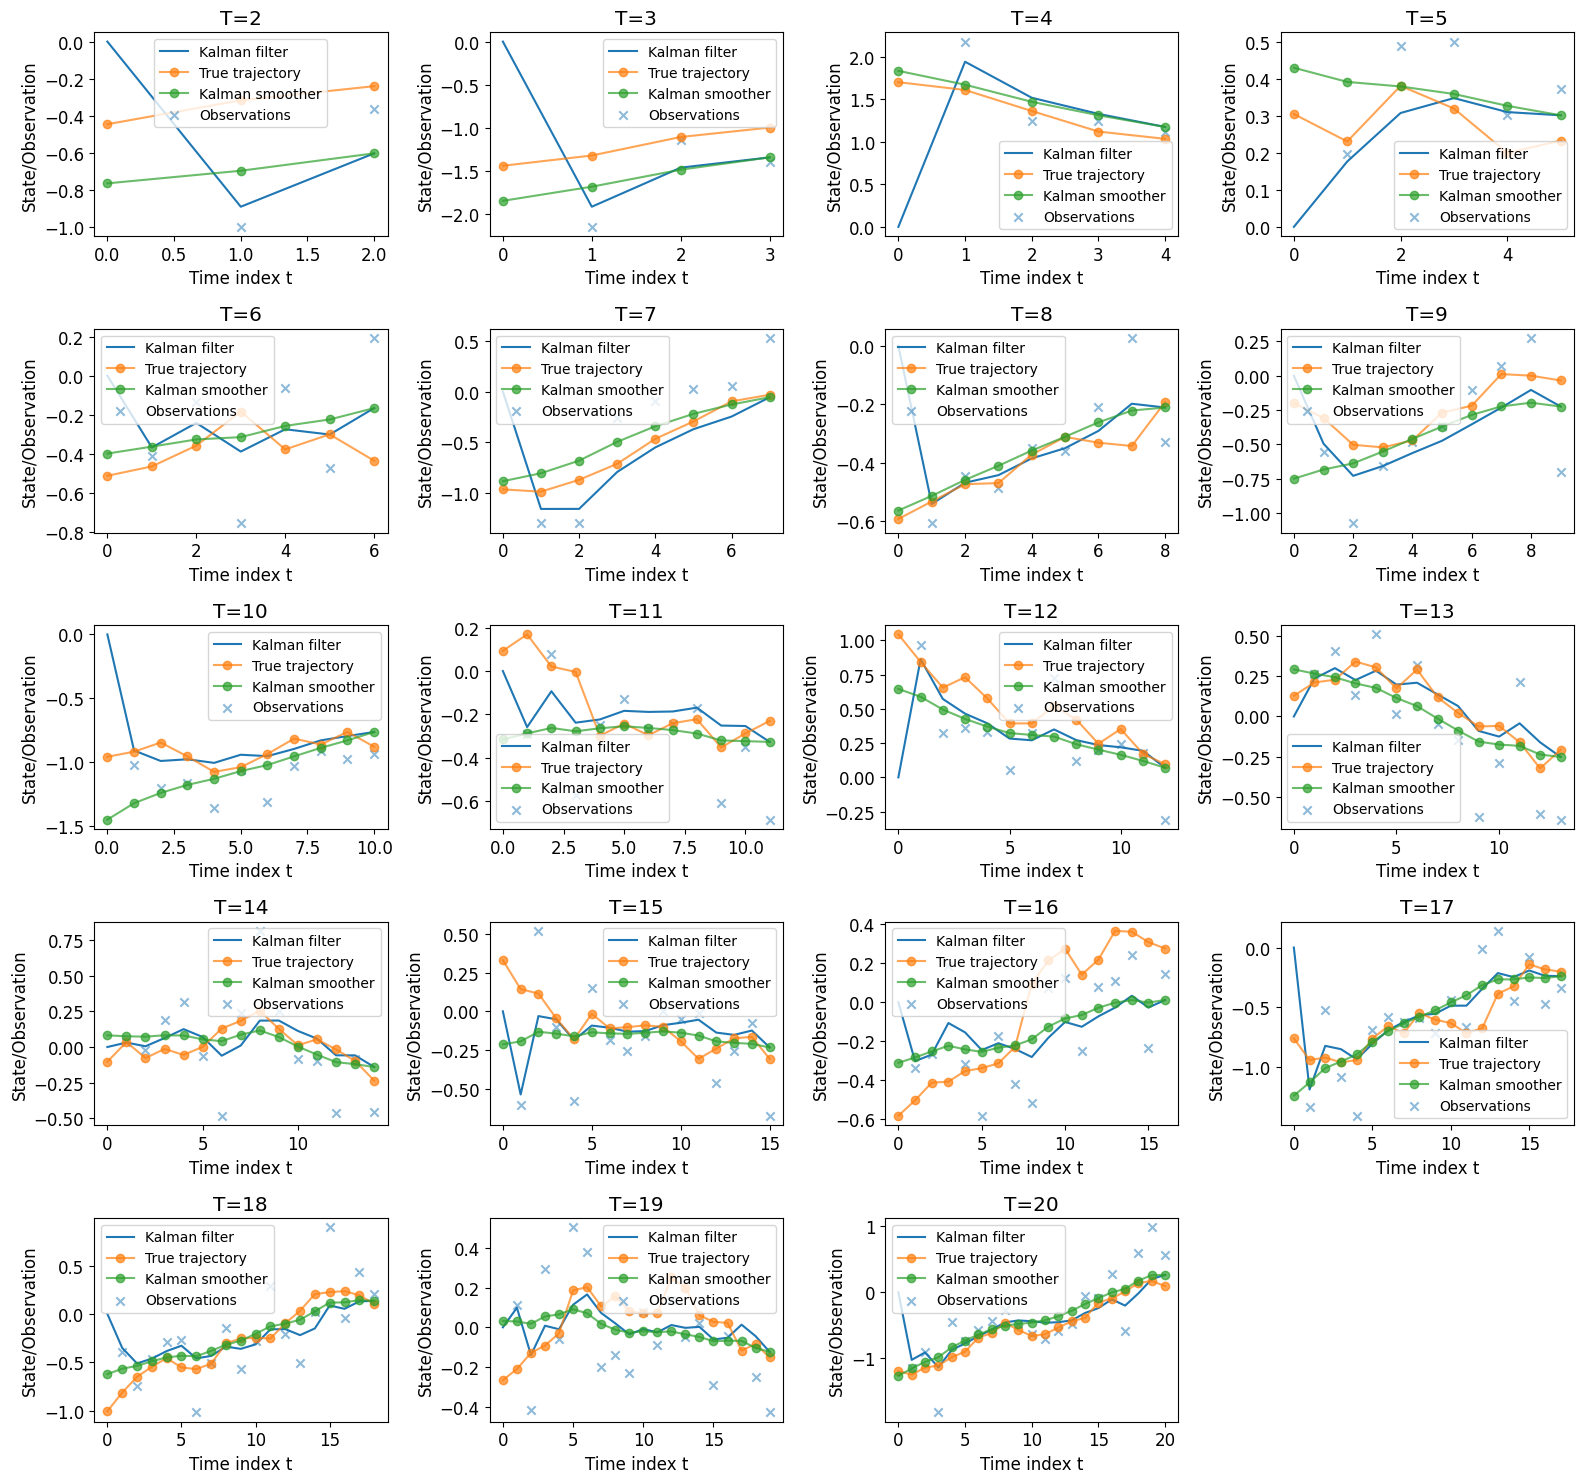

In [23]:

def kalman(T, m0=0, P0=1, A=0.9, Q=0.01, H=1, R=0.1):
    '''Implement Kalman filter and smoother for given data'''
    ds = datasets[T] # fetch saved dataset
    x, y = ds[0], ds[1]
    m = np.zeros(T)
    P = np.zeros(T)

    m_pred = np.zeros(T)
    P_pred = np.zeros(T)

    # First step
    m_pred[0] = A * m0
    P_pred[0] = A * P0 * A + Q

    K = P_pred[0] * H / (H * P_pred[0] * H + R)
    m[0] = m_pred[0] + K * (y[0] - H * m_pred[0])
    P[0] = P_pred[0] - K * H * P_pred[0]

    # Filtering loop
    for t in range(1, T):
        m_pred[t] = A * m[t - 1]
        P_pred[t] = A * P[t - 1] * A + Q
        
        K = P_pred[t] * H / (H * P_pred[t] * H + R)
        m[t] = m_pred[t] + K * (y[t] - H * m_pred[t])
        P[t] = P_pred[t] - K * H * P_pred[t]
    
    # Kalman Smoother
    m_smooth = np.zeros(T)
    P_smooth = np.zeros(T)

    m_smooth[-1] = m[-1]
    P_smooth[-1] = P[-1]

    for t in range(T-2, -1, -1):
        J = P[t] * A / P_pred[t+1]
        m_smooth[t] = m[t] + J * (m_smooth[t+1] - m_pred[t+1])
        P_smooth[t] = P[t] + J * (P_smooth[t+1] - P_pred[t+1]) * J

    J = P0 * A / P_pred[0]
    m_smooth_0 = m0 + J * (m_smooth[0] - m_pred[0])
    P_smooth_0 = P0 + J * (P_smooth[0] - P_pred[0]) * J

    m_smooth = np.concatenate(([m_smooth_0], m_smooth))
    m = np.concatenate(([m0], m))

    # note m_smooth is our estimate of the posterior mean
    # m is the kalman filter estimate
    return x, y, m, m_smooth

fig, axes = plt.subplots(5, 4, figsize=(16, 15))
axes = axes.flatten()  # Flatten to easily iterate

m_smooths = {} # save estimates for each T

for idx, T in enumerate(range(2, 21)):
    x, y, m, m_smooth = kalman(T)
    m_smooths[T] = m_smooth
    ax = axes[idx]  # Select corresponding subplot
    ax.plot(range(T+1), m, label="Kalman filter")

    ax.plot(range(T+1), x, label="True trajectory", 
            alpha=0.7, linestyle='-', marker='o')
    
    ax.plot(range(T+1), m_smooth, label="Kalman smoother",
            alpha=0.7, linestyle='-', marker='o')

    ax.scatter(range(1, T+1), y, alpha=0.5, 
               marker='x', label="Observations")

    ax.set_title(f"T={T}")
    ax.set_xlabel("Time index t")
    ax.set_ylabel("State/Observation")
    ax.legend(fontsize='small')

# Remove any empty subplots (if necessary)
for i in range(len(range(2, 21)), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### 2.4

We know that the posterior is proportional to the full joint distribution:

$p(x_{0:T}| y_{1:T}) \propto \Pi_T (x_{0:T}) =
p(x_0) \prod_{k=1}^{T} \tau_k(x_k \mid x_{k-1}) g_k(y_k \mid x_k).$

We use proposal $q(x_{0:T}) = \prod_{k=0}^{T} q(x_k) 
= \prod_{k=0}^{T} \mathcal{N}(x_k; 0, \sigma_{\text{IS}}^2)$ for SNIS,

we have that the unnormalized weight is

$$
W_n(x_{0:T}) = \frac{ \Pi_T (x_{0:T}) }{ q(x_{0:T}) }
$$

And the SNIS algo is given by
- Fix $K, \sigma_{IS}$
- Sample $\{x_{0:T}^{(i)}\}_{i=1}^{K}$ from $q = \mathcal{N}(0, \sigma_{\text{IS}}^2)$.
- Compute unnormalised weights $W_T^{(i)} = \frac{\Pi_T(x_{0:T}^{(i)})}{q(x_{0:T}^{(i)})}$.
- Normalize weights $w_T^{(i)} = \frac{W_T^{(i)}}{\sum_{j=1}^{N} W_T^{(j)}}$, 

And we obtain the SNIS estimate of the posterior mean: 
$$
\bar{m}_{0:T}^{(T)} = \sum_{i=1}^{K} w_T^{(i)} x_{0:T}^{(i)}
$$

### 2.5

In [24]:
# first define log densities

def log_gaussian(x, mean, variance):
    return -0.5 * (np.log(2 * np.pi * variance) + ((x - mean) ** 2) / variance)

def log_prior(x0, m0=0, P0=1):
    return log_gaussian(x0, m0, P0)

def log_transition(x, A=0.9, Q=0.01):
    return log_gaussian(x[1:], A * x[:-1], Q).sum()

def log_observation(y, x, H=1, R=0.1):
    return log_gaussian(y, H * x, R).sum()

def log_q(x, sigma_IS):
    return log_gaussian(x, 0, sigma_IS).sum()

def log_joint(x, y, m0=0, P0=1, A=0.9, Q=0.01, H=1, R=0.1):
    return (log_prior(x[0], m0, P0) + log_transition(x[1:], A, Q) 
            + log_observation(y, x[1:], H, R)
)


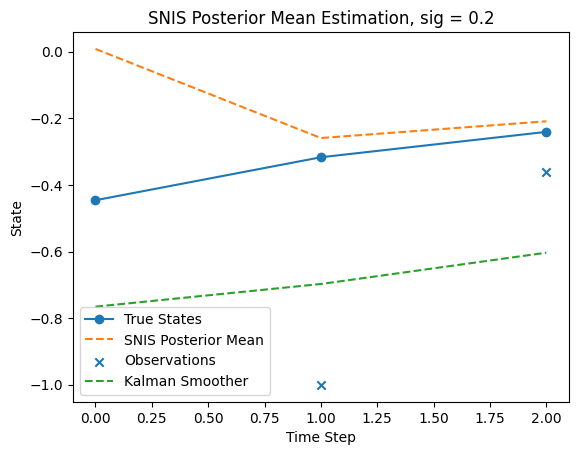

In [25]:
rng = np.random.default_rng(42)
# set small font size
plt.rcParams.update({'font.size': 10})

def SNIS(T, K, sigma_IS, m0=0, P0=1, A=0.9, Q=0.01, H=1, R=0.1):
    '''Implement Sequential Importance Sampling for given data.'''

    x_true, y_obs = datasets[T][0], datasets[T][1]
    
    # proposal
    x_samples = rng.normal(0, sigma_IS, size=(K, T+1))
    logw = np.zeros(K)
    for i in range(K):
        logw[i] = (log_joint(x_samples[i,:], y_obs) 
                   - log_q(x_samples[i,:], sigma_IS))
    logw = logw - np.max(logw) # to avoid numerical issues
    w = np.exp(logw)/np.sum(np.exp(logw)) # normalising the weights

    # we want to dot product (K,) weights with each of the 
    # K paths, each of (T+1,) length, and return the 
    # (T+1,) length mean

    return x_true, y_obs, w.dot(x_samples), w
    

# Set parameters
T = 2  # Number of time steps
K = 10000  # Number of particles
sigma_IS = 0.2  # Proposal distribution std deviation
# I use sig = 0.2 here

x_true, y_obs, posterior_mean, _ =  SNIS(T, K, sigma_IS)

plt.plot(range(T+1), x_true, label='True States', marker='o')
plt.plot(range(T+1), posterior_mean, 
         label='SNIS Posterior Mean', linestyle='--')
plt.scatter(range(1, T+1), y_obs, label='Observations', marker='x')
plt.plot(range(T+1), m_smooths[T], 
         label='Kalman Smoother', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.legend()
plt.title(f'SNIS Posterior Mean Estimation, sig = {sigma_IS}')
plt.show()

Note I use sig = 0.2 here

Increasing sig to around 0.7 will move the SNIS estimate closer to the Kalman smoother
by a little bit.

But later the MSE will suffer with larger T. Therefore we keep 0.2 here


We also reference from the lecture notes that 
to optimize memory usage and speed up the algo, we can use
sequential IS:


- **Sample:** $x_0^{(i)} \sim q(x_0)$ for $i = 1, \dots, N$.

- **Weight:**
  
  $$
  W_0^{(i)} = \frac{\pi_0(x_0^{(i)})}{q(x_0^{(i)})},
  $$

  for $i = 1, \dots, K$.

- **For** $n = 1, \dots, T$ **do**
  - **Sample:** $x_n^{(i)} \sim q(x_n | x_{n-1}^{(i)})$ for $i = 1, \dots, N$.
  - **Weight:**
    
    $$
    W_n^{(i)} = \frac{\tau_n(x_n^{(i)} | x_{n-1}^{(i)}) g_n(y_n | x_n^{(i)})}{q(x_n^{(i)} | x_{n-1}^{(i)})} W_{n-1}^{(i)},
    $$

    for $i = 1, \dots, K$.

  - Compute

    $$
    w_n^{(i)} = \frac{W_n^{(i)}}{\sum_{j=1}^{N} W_n^{(j)}},
    $$

    for $i = 1, \dots, K$.

- **End for**

I have also implemented SIS below, and tune sigma to be 0.2. In fact changing sigma doesn't
make a big difference in the T=2 case

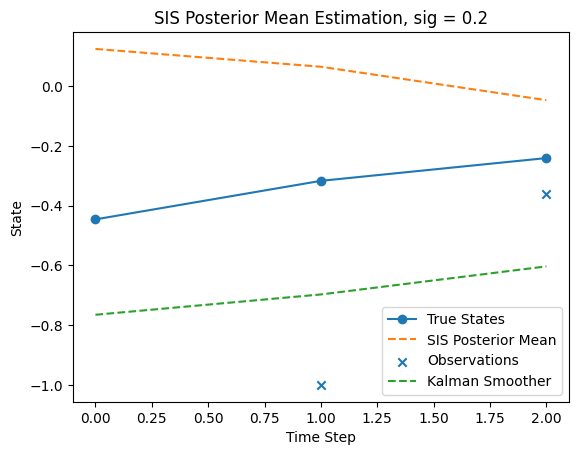

In [26]:
rng = np.random.default_rng(42)
def SIS(T, K, sigma_IS, m0=0, P0=1, A=0.9, Q=0.01, H=1, R=0.1):
    '''Implement Sequential Importance Sampling for given data.'''

    x_true, y_obs = datasets[T][0], datasets[T][1]
    
    # proposal
    x_samples = rng.normal(0, sigma_IS, size=(K, T+1))
    W = np.zeros((K, T+1))
    
    # Initial weights
    # Compute prior probability π_0(x_0) = N(m_0, P_0)
    prior_prob = (np.exp(-0.5 * ((x_samples[:, 0] - m0) ** 2) / P0) 
                / np.sqrt(2 * np.pi * P0))

    # Compute proposal probability q(x_0) = N(0, σ_IS^2)
    proposal_prob = (np.exp(-0.5 * (x_samples[:, 0] ** 2) /sigma_IS**2) 
                    / np.sqrt(2 * np.pi * sigma_IS**2))

    # Compute unnormalized weights
    W[:, 0] = prior_prob / proposal_prob
    logW = np.log(W[:, 0]) # (K, ) log weight

    # Sequential importance sampling loop
    for n in range(1, T+1):
        # Sample from the proposal distribution q(x_n | x_n-1)
        x_samples[:, n] = rng.normal(0, sigma_IS, size=K)
        
        # Compute transition probability τ_n(x_n | x_n-1)
        log_tau = log_transition(x_samples[:, n], A, Q)

        # Compute likelihood g_n(y_n | x_n)
        log_g = log_observation(y_obs[n-1], x_samples[:, n], H, R)
        
        log_proposal = log_q(x_samples[:, n], sigma_IS)

        logW += log_tau + log_g - log_proposal
        
        logW -= np.max(logW)  # Avoid overflow
        W[:, n] = np.exp(logW - np.log(np.sum(np.exp(logW))))  # Normalize in log-space
        # Compute importance weights
        # W[:, n] = np.exp(log_tau + log_g - log_proposal) * W[:, n-1]
        
        # Normalize weights
        W[:, n] /= np.sum(W[:, n])
    
    # Compute posterior mean estimate
    posterior_mean = np.sum(W[:, -1][:, np.newaxis] * x_samples, axis=0)
    w = W[:, -1]

    
    return x_true, y_obs, posterior_mean, w


# Set parameters
T = 2  # Number of time steps
K = 10000  # Number of particles
sigma_IS = 0.2  # Proposal distribution std deviation

x_true, y_obs, posterior_mean, _ =  SIS(T, K, sigma_IS)

plt.plot(range(T+1), x_true, label='True States', marker='o')
plt.plot(range(T+1), posterior_mean, 
         label='SIS Posterior Mean', linestyle='--')
plt.scatter(range(1, T+1), y_obs, label='Observations', marker='x')
plt.plot(range(T+1), m_smooths[T], 
         label='Kalman Smoother', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.legend()
plt.title(f'SIS Posterior Mean Estimation, sig = {sigma_IS}')
plt.show()

From T = 2 plot, we can notice SIS is somewhat close to the smoother, which is closer to the true states. But not much can be said with three datapoints.

Since SIS and SNIS give very different results, we visualize them for some T,
namely T = 5, 10, 15 

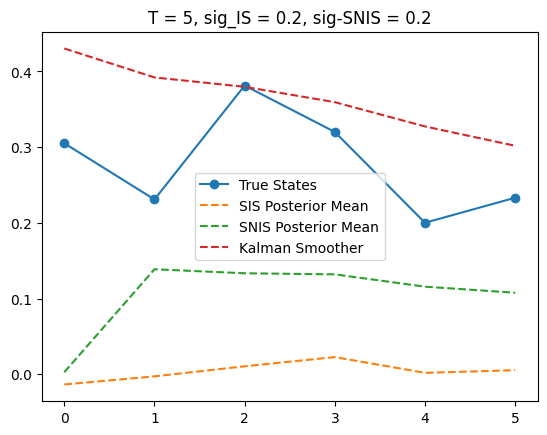

In [27]:
T = 5

sigma_IS = 0.2  # Proposal distribution std deviation
sigma_SNIS = 0.2
x_true, y_obs, posterior_mean, _ =  SIS(T, K, sigma_IS)
x_true, y_obs, posterior_mean_SNIS, _ =  SNIS(T, K, sigma_SNIS)
plt.plot(x_true, label='True States', marker='o')
plt.plot(posterior_mean, 
        label='SIS Posterior Mean', linestyle='--')
plt.plot(posterior_mean_SNIS,
        label='SNIS Posterior Mean', linestyle='--')
plt.plot(m_smooths[T], 
        label='Kalman Smoother', linestyle='--')
plt.title(f'T = {T}, sig_IS = {sigma_IS}, sig-SNIS = {sigma_SNIS}')
plt.legend()

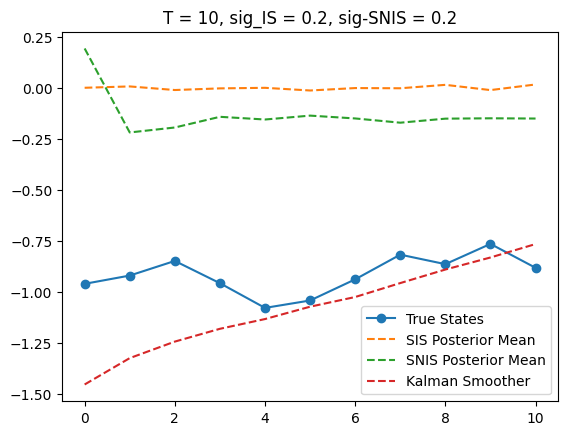

In [28]:
T = 10
x_true, y_obs, posterior_mean, _ =  SIS(T, K, sigma_IS)
x_true, y_obs, posterior_mean_SNIS, _ =  SNIS(T, K, sigma_SNIS)
plt.plot(x_true, label='True States', marker='o')
plt.plot(posterior_mean, 
        label='SIS Posterior Mean', linestyle='--')
plt.plot(posterior_mean_SNIS,
        label='SNIS Posterior Mean', linestyle='--')
plt.plot(m_smooths[T], 
        label='Kalman Smoother', linestyle='--')
plt.title(f'T = {T}, sig_IS = {sigma_IS}, sig-SNIS = {sigma_SNIS}')
plt.legend()

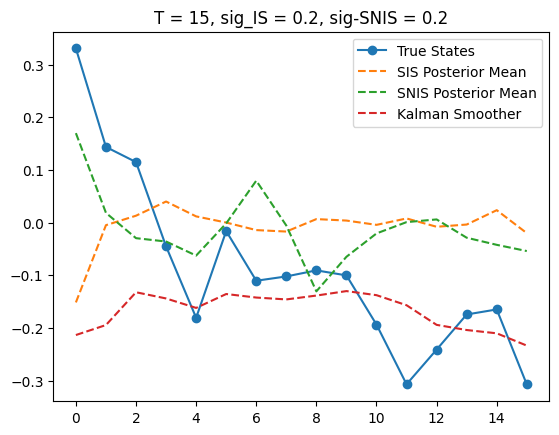

In [29]:
T = 15 
x_true, y_obs, posterior_mean, _ =  SIS(T, K, sigma_IS)
x_true, y_obs, posterior_mean_SNIS, _ =  SNIS(T, K, sigma_SNIS)
plt.plot(x_true, label='True States', marker='o')
plt.plot(posterior_mean, 
        label='SIS Posterior Mean', linestyle='--')
plt.plot(posterior_mean_SNIS,
        label='SNIS Posterior Mean', linestyle='--')
plt.plot(m_smooths[T], 
        label='Kalman Smoother', linestyle='--')
plt.title(f'T = {T}, sig_IS = {sigma_IS}, sig-SNIS = {sigma_SNIS}')
plt.legend()

We notice that despite SIS being further from the smoother than SNIS for some T

They perform roughly at the smae level. SIS is smoother whereas SNIS has more fluctuations

### 2.6

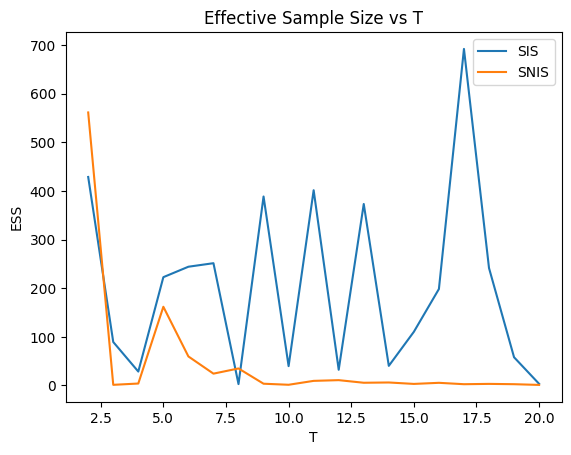

In [30]:
def ESS(w): # To measure sample quality
    return 1/np.sum(w**2)

sigma_IS = 0.2
sigma_SNIS = 0.2
ESS_SIS = []
ESS_SNIS = []
NMSE_SIS = []
NMSE_SNIS = []
for T in range(2, 21):
    x_true, y_obs, posterior_mean_SNIS, w_SNIS =  SNIS(T, K, sigma_SNIS)
    x_true, y_obs, posterior_mean, w_SIS =  SIS(T, K, sigma_IS) 

    ESS_SIS.append(ESS(w_SIS))
    ESS_SNIS.append(ESS(w_SNIS))
    nmse_SIS = (np.sum((m_smooths[T] - posterior_mean)**2) 
            / np.linalg.norm(m_smooths[T])**2
)
    nmse_SNIS = (np.sum((m_smooths[T] - posterior_mean_SNIS)**2)
            / np.linalg.norm(m_smooths[T])**2
)
    NMSE_SIS.append(nmse_SIS)
    NMSE_SNIS.append(nmse_SNIS)


plt.plot(range(2, 21), ESS_SIS, label='SIS')
plt.plot(range(2, 21), ESS_SNIS, label='SNIS')
plt.xlabel('T')
plt.ylabel('ESS')
plt.title('Effective Sample Size vs T')
plt.legend()
plt.show()

We notice that given K = 10000, both SIS and SNIS suffer from weight degeneracy,
with a small number of particles dominating. 

SNIS has a fair ESS for small T, but quickly deteriorates to a very low level (less than 0.1% of K) and stay there. SIS has some more fluctuations in terms of ESS for larger T.

But both stay below 1000 for T > 5, which is 1/10 of K.

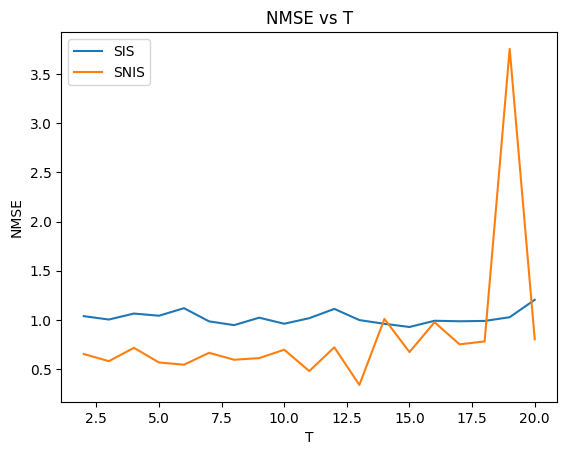

In [31]:
plt.plot(range(2, 21), NMSE_SIS, label='SIS')
plt.plot(range(2, 21), NMSE_SNIS, label='SNIS')
plt.legend()
plt.xlabel('T')
plt.ylabel('NMSE')
plt.title('NMSE vs T')
plt.show()

Again we notice both demonstrate a fairly small NMSE, with the MSE being roughly as large as the squared norm of the smoother estimate. 

There are some fluctuations of around 60% for both, with SIS having a higher NMSE for most T (this may change if I re-run many times)

The increasing trend is more obvious for SNIS than for SIS, but we can conclude from the ESS plot that larger T make estimating expectations harder,
and in general should increase MSE, due to weight degeneracy. 

Expectation estimation gets harder with larger state-space dimensions.